In [1]:
import pickle
import pandas as pd
import nltk
import re
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

In [2]:
exu_df = pd.read_pickle('../pickle_jar/EXU_split.pkl')
d20_df = pd.read_pickle('../pickle_jar/D20_split.pkl')

In [3]:
exu_df = exu_df.reset_index()
exu_df['player'] = exu_df['name']
exu_df.drop(columns='timestamp', inplace=True)
exu_df = exu_df.iloc[:, [0, 1, 7, 2, 3, 4, 5, 6]]

In [4]:
all_abbria = [exu_df, d20_df]
d20_df = pd.concat(all_abbria)
d20_df['player'] = d20_df['player'].str.upper()
d20_df = d20_df.rename(columns={'text': 'speech'})
d20_df

,index,name,player,speech,episode,inaudible_speech,nonspeech,season
0,0,AABRIA,AABRIA,Let's start with Robbie.,1,,,EXU
1,1,ROBBIE,ROBBIE,I'm so excited!,1,,,EXU
2,2,AABRIA,AABRIA,Yeah!,1,,,EXU
3,3,ROBBIE,ROBBIE,Whew!,1,,,EXU
4,4,AABRIA,AABRIA,Liam!,1,,,EXU
...,...,...,...,...,...,...,...,...
76015,1244,Aabria,AABRIA,your hard work. This is literally what we mean...,5,,,Misfits and Magic AP
76016,1245,Aabria,AABRIA,"collaborative storytelling, We all built this ...",5,,,Misfits and Magic AP
76017,1246,Aabria,AABRIA,"an honor and a privilege to get to build ""Misf...",5,,,Misfits and Magic AP
76018,1247,Aabria,AABRIA,"it right one time, thank God.",5,,,Misfits and Magic AP


In [5]:
d20_df['player'] = d20_df['player'].str.replace(r'AAABRIA', r'AABRIA', regex=True).astype('str') #correct 1 misspelling

Before I can get started with line counts and so on, we have to face off with a quirk of this dataset caused by the original format of the data before it was processed. In the seasons from Dimension 20 specifically, the data has one speech turn split up over multiple lines all the time, even mid-sentence.

Look at the intro from one episode below... This is undeniably one turn of speech for the DM, Aabria, but because of the formatting of the data, it's split over 10 DF rows!

In [6]:
ACO = d20_df[d20_df['season']=="ACOFF"]
ep1 = ACO[ACO['episode']=='10']
ep1.head(n=11)

,index,name,player,speech,episode,inaudible_speech,nonspeech,season
0,10,Aabria,AABRIA,"To the churlish Captain K.P. Hob, venerated s...",10,,,ACOFF
1,11,Aabria,AABRIA,"Goblin Court. To the master of ceremonies, Del...",10,,,ACOFF
2,12,Aabria,AABRIA,"the Court of Wonder. To BINX Choppley, sole su...",10,,,ACOFF
3,13,Aabria,AABRIA,"Craft. To the tenebrous Prince Andhera, scion ...",10,,,ACOFF
4,14,Aabria,AABRIA,"to the notorious Lords of the Wing, Lady Chirp...",10,,,ACOFF
5,15,Aabria,AABRIA,"Cluckingham, and Lord Squak Airavis, Earl of P...",10,,,ACOFF
6,16,Aabria,AABRIA,"archfey, we are delighted to welcome you to A ...",10,,,ACOFF
7,17,Aabria,AABRIA,"Hello, and welcome to Dimension 20's A Court o...",10,,,ACOFF
8,18,Aabria,AABRIA,"thrilling finale. I am your Dungeon Master, Aa...",10,,,ACOFF
9,19,Aabria,AABRIA,"one last time, are my pack of pixies. Say hi, ...",10,,,ACOFF


To take care of this, let's merge rows sharing information from the "name" column when in sequence

In [7]:
cond_d20 = d20_df.assign(key=d20_df['player'].ne(d20_df['player'].shift()).cumsum())\
        .groupby('key').agg({'player': 'first', 'speech': ' '.join})\
        .reset_index()

In [8]:
cond_d20=cond_d20.drop(8029) #odd row that had no value in any column

This condensed DF is what we'll work with, for these purposes, so that tokenizing and counts will be as accurate as possible. As a note, the uncondensed version of the dataframe contains 98923 rows, and the condensed version contains 64348  rows. 

To compare, let's check out that 10 line intro speech from above now. It looks much much better!

In [9]:
cond_d20.speech[34634]

' To the churlish Captain K.P. Hob, venerated soldier of the Goblin Court. To the Master of Ceremonies, Delloso de la Rue, pride of the Court of Wonder. To BINX Choppley, sole survivor of the Court of Craft. To the tenebrous Prince Andhera, scion of the Unseelie Court. And to the notorious Lords of the Wing, Lady Chirp Featherfowl, Countess of Cluckingham, and Lord Squak Airavis, Earl of Peckersburg. Honored archfey, we are delighted to welcome you to "A Court of Fey & Flowers". Greetings, and welcome to Dimension 20\'s "A Court of Fey & Flowers". I am your Dungeon Master, Aabria Iyengar, and with me, taking center stage, are my pack of pixies. Say hi, pack of pixies!'

### One step more

So the data here contains a LOT of data that doesn't belong to either DM or player. This is sometimes a guest who comes in to talk about the prouction of the show, maybe only a line or two, but in my early looks at working with the data, it's affecting the counts and visualizations quite a lot. To combat this, I'm going to select for only the main cast in the dataframe (confirmed by cast lists online). That will simplify the analysis quite a lot.

The results of this means we only lose 746 rows of data, but will be a much cleaner analysis thanks to it.

In [10]:
cond_d20 = cond_d20[cond_d20['player'].isin(['AABRIA', 'ROBBIE', 'LIAM', 'ASHLEY', 'MATT', 'AIMEE', 'OMAR', 'ANJALI', 'EMILY', 'LOU', 'OSCAR', 'BRENNAN', 'SURENA', 'RASHAWN', 'JASPER', 'SIOBHAN', 'IZZY', 'ERIKA', 'DANIELLE'])]

# Table of Contents

### Part 1

1. [Counting Lines](#Counting-Lines)
    - [Exploring Results](#Exploring-Results)<br>
    <br>
2. [Adding new columns](#Adding-new-columns)
    - [Word Counts](#Word-Counts-(per-spoken-line))
    - [Words per Speaker](#Total-words-per-speaker)
    - [Unique Words per Speaker](#Unique-Words-per-Speaker)
    - [Sentences and sentence length](#Sentences-and-sentence-length)<br>
    <br>
3. [Initial Conlusions](#Initial-Conlusions)

### Part 2

1. [Dividing the Data](#Dividing-the-Data)<br>
    <br>
2. [Re-measuring](#Re-measuring)
    - [Lines](#Lines)
    - [Word Count](#Word-Count)
    - [Sentence Length](#Sentence-Length)<br>
    <br>
3. [Grouped Conclusions](#Grouped-Conclusions)

### Part 3

1. [Hedging](#Hedging)
2. [Jargon](#Jargon)
3. [Readability Metric](#Readability-Metric)
4. [Readability Redux](#Readability-Redux)
5. [Interruptions](#Interruptions)

## Counting Lines

In [11]:
lcount = cond_d20[['player', 'speech']].copy() #copy just these two cols over for now
lcount = lcount[lcount['speech'] != '']  #drop any rows with no value

In [12]:
spcount = pd.DataFrame(lcount.groupby(['player'])['speech'].count()) #speech count
spcount = spcount.reset_index()
spcount = spcount.sort_values('speech', ascending=False)
spcount.head(n=8)

,player,speech
0,AABRIA,19488
4,BRENNAN,5537
11,LOU,4293
1,AIMEE,4041
7,ERIKA,3106
12,MATT,2643
3,ASHLEY,2572
6,EMILY,2480


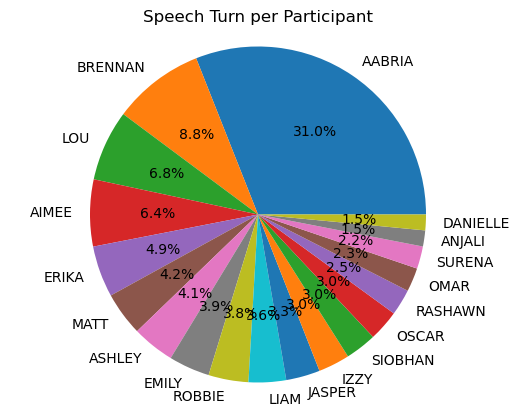

In [13]:
plt.pie(spcount['speech'], labels=spcount['player'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Speech Turn per Participant')
plt.show()

## Exploring Results 

As done with the Critical Role line count, it's important to look at the context of this data itself. 

1. How is this data different to the CR data?

What we're looking at is 4 seasons of liveplay D&D shows and 3 seasons of post-game chat style shows adding up to 54 total episodes. Each of those 4 seasons is a different campaign, a different story, and (mostly) a different cast. 

These are:<br>
Burrow's Edge (a story about stoats)<br>
Misfits and Magic (a story about a magic school)<br>
Exandria Unlimited (a Critical Role side story)<br>
A Court of Fey & Flowers (a fey realm Bridgerton inspired regency romance thing)

It's important, again, to consider attendence. These campaigns are much shorter than CR, 10 or 11 episodes at the longest, not running over years. No one is missing an episode, but some players appear in more than one campaign. In this case, Brennan appears in 3 campaigns, and Erika and Lou appear in 2. Everyone else only being present in one campaign alone may explain why those three are among the highest represented in terms of line count.

## Adding new columns

Running through the base metrics we know and love.... word tokenizing & word counts, word types, sentence count and sentence length. With these metrics available, the real interpretation can begin.

I've opted not to calculate average word length for this data. It wasn't particularly informative for the CR data, and won't be a metric I'll be considering in my comparisons.

### Word Counts (per spoken line)

Calculating the word counts per speech turn (not per sentence). Punctuation excluded once again, because it is not part of the spoken unit. 

In [14]:
punctuations="!@#$%^&*()_-=+:;{}[]<>,.?/\''"

In [15]:
tokens = cond_d20.speech.map(nltk.word_tokenize)
cond_d20['tokens']=tokens         #create token column
cond_d20['nopunc']=cond_d20['tokens'].apply(lambda tokens: [w for w in tokens if w not in punctuations]) #list comprehend to remove toks
cond_d20 = cond_d20.drop('tokens', axis=1)     #drop that toks col, we don't actually want it

In [16]:
cond_d20['word_count'] = cond_d20.nopunc.map(len)   #count total tokens per line
cond_d20.head() 

,key,player,speech,nopunc,word_count
0,1,AABRIA,Let's start with Robbie.,"[Let, 's, start, with, Robbie]",5
1,2,ROBBIE,I'm so excited!,"[I, 'm, so, excited]",4
2,3,AABRIA,Yeah!,[Yeah],1
3,4,ROBBIE,Whew!,[Whew],1
4,5,AABRIA,Liam!,[Liam],1


### Total words per speaker

In [17]:
wcount = pd.DataFrame(cond_d20.groupby('player').word_count.sum())
wcount = wcount.reset_index()
wcount = wcount.sort_values('word_count', ascending=False)
wcount.head(n=8)

,player,word_count
0,AABRIA,307361
4,BRENNAN,113331
11,LOU,52439
7,ERIKA,37242
9,JASPER,26692
6,EMILY,25874
13,OMAR,23721
14,OSCAR,23609


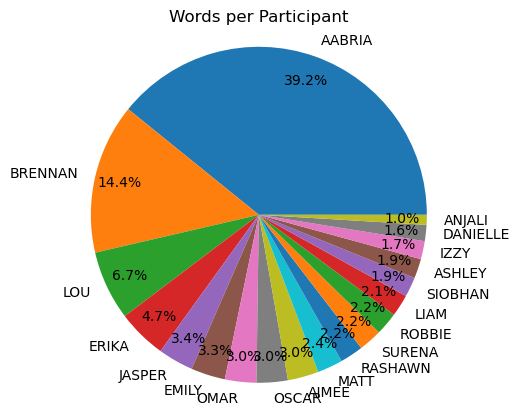

In [18]:
plt.pie(wcount['word_count'], labels=wcount['player'], autopct='%1.1f%%', pctdistance=.85)
plt.axis('equal') 
plt.title('Words per Participant')
plt.show()

Also not so unexpected. 

Considering again the question of attendance Brennan is in 3 seasons of the data, averaging out his 14.4% total to a roughly 4.8% per season. Lou drops to arounf 3.4% per season, and Erika to 2.4%, putting most of the players in a very similar range. 

### Unique words per line

In [19]:
cond_d20['types'] = cond_d20['nopunc'].apply(lambda tokens: [w.lower() for w in tokens])
cond_d20['types'] = cond_d20['types'].apply(set)
cond_d20['type_count'] = cond_d20.types.map(len) 
cond_d20.head() #again to confirm, before punc removal type count for index 0 was 95

,key,player,speech,nopunc,word_count,types,type_count
0,1,AABRIA,Let's start with Robbie.,"[Let, 's, start, with, Robbie]",5,"{'s, start, robbie, with, let}",5
1,2,ROBBIE,I'm so excited!,"[I, 'm, so, excited]",4,"{so, i, excited, 'm}",4
2,3,AABRIA,Yeah!,[Yeah],1,{yeah},1
3,4,ROBBIE,Whew!,[Whew],1,{whew},1
4,5,AABRIA,Liam!,[Liam],1,{liam},1


### Unique Words per Speaker

In [20]:
aabria = pd.DataFrame(cond_d20[cond_d20['player']=='AABRIA'])
robbie = pd.DataFrame(cond_d20[cond_d20['player']=='ROBBIE'])
liam = pd.DataFrame(cond_d20[cond_d20['player']=='LIAM'])
ashley = pd.DataFrame(cond_d20[cond_d20['player']=='ASHLEY'])
matt = pd.DataFrame(cond_d20[cond_d20['player']=='MATT'])
aimee = pd.DataFrame(cond_d20[cond_d20['player']=='AIMEE'])
omar = pd.DataFrame(cond_d20[cond_d20['player']=='OMAR'])
anjali = pd.DataFrame(cond_d20[cond_d20['player']=='ANJALI'])
emily = pd.DataFrame(cond_d20[cond_d20['player']=='EMILY'])
lou = pd.DataFrame(cond_d20[cond_d20['player']=='LOU'])
oscar = pd.DataFrame(cond_d20[cond_d20['player']=='OSCAR'])
brennan = pd.DataFrame(cond_d20[cond_d20['player']=='BRENNAN'])
surena = pd.DataFrame(cond_d20[cond_d20['player']=='SURENA'])
rashawn = pd.DataFrame(cond_d20[cond_d20['player']=='RASHAWN'])
jasper = pd.DataFrame(cond_d20[cond_d20['player']=='JASPER'])
siobhan = pd.DataFrame(cond_d20[cond_d20['player']=='SIOBHAN'])
izzy = pd.DataFrame(cond_d20[cond_d20['player']=='IZZY'])
erika = pd.DataFrame(cond_d20[cond_d20['player']=='ERIKA'])
danielle = pd.DataFrame(cond_d20[cond_d20['player']=='DANIELLE'])

In [21]:
aabtypes = aabria['types'].tolist()
aabtypes = list(itertools.chain(*aabtypes))
ashset = set(aabtypes)
print(len(ashset))

robtypes = robbie['types'].tolist()
robtypes = list(itertools.chain(*robtypes))
robset = set(robtypes)
print(len(robset))

liamtypes = liam['types'].tolist()
liamtypes = list(itertools.chain(*liamtypes))
liamset = set(liamtypes)
print(len(liamset))

ashtypes = ashley['types'].tolist()
ashtypes = list(itertools.chain(*ashtypes))
ashset = set(ashtypes)
print(len(ashset))

matttypes = matt['types'].tolist()
matttypes = list(itertools.chain(*matttypes))
mattset = set(matttypes)
print(len(mattset))

aimtypes = aimee['types'].tolist()
aimtypes = list(itertools.chain(*aimtypes))
aimset = set(aimtypes)
print(len(aimset))

omtypes = omar['types'].tolist()
omtypes = list(itertools.chain(*omtypes))
omset = set(omtypes)
print(len(omset))

anjtypes = anjali['types'].tolist()
anjtypes = list(itertools.chain(*anjtypes))
anjset = set(anjtypes)
print(len(anjset))

emtypes = emily['types'].tolist()
emtypes = list(itertools.chain(*emtypes))
emset = set(emtypes)
print(len(emset))

loutypes = lou['types'].tolist()
loutypes = list(itertools.chain(*loutypes))
louset = set(loutypes)
print(len(louset))

osctypes = oscar['types'].tolist()
osctypes = list(itertools.chain(*osctypes))
oscset = set(osctypes)
print(len(oscset))

brentypes = brennan['types'].tolist()
brentypes = list(itertools.chain(*brentypes))
brenset = set(brentypes)
print(len(brenset))

surtypes = surena['types'].tolist()
surtypes = list(itertools.chain(*surtypes))
surset = set(surtypes)
print(len(surset))

rastypes = rashawn['types'].tolist()
rastypes = list(itertools.chain(*rastypes))
rasset = set(rastypes)
print(len(rasset))

jastypes = jasper['types'].tolist()
jastypes = list(itertools.chain(*jastypes))
jasset = set(jastypes)
print(len(jasset))

siotypes = siobhan['types'].tolist()
siotypes = list(itertools.chain(*siotypes))
sioset = set(siotypes)
print(len(sioset))

izztypes = izzy['types'].tolist()
izztypes = list(itertools.chain(*izztypes))
izzset = set(izztypes)
print(len(izzset))

eritypes = erika['types'].tolist()
eritypes = list(itertools.chain(*eritypes))
eriset = set(eritypes)
print(len(eriset))

danitypes = danielle['types'].tolist()
danitypes = list(itertools.chain(*danitypes))
daniset = set(danitypes)
print(len(daniset))

12664
2118
2263
1580
2355
2155
2967
1176
2976
4306
2744
7520
2276
2258
2564
1776
1701
3893
1667


In [22]:
alltypes = {'AABRIA':[12664], 'ROBBIE':[2118], 'LIAM':[2263], 'ASHLEY':[1580], 'MATT':[2355], 'AIMEE':[2155], 'OMAR':[2967], 'ANJALI':[1176], 'EMILY':[2976], 'LOU':[4306], 'OSCAR':[2744], 'BRENNAN':[7520], 'SURENA':[2276], 'RASHAWN':[2258], 'JASPER':[2564], 'SIOBHAN':[1776], 'IZZY':[1701], 'ERIKA':[3893], 'DANIELLE':[1667]}

In [23]:
typecount = pd.DataFrame(alltypes)
typecount = typecount.melt()
typecount = typecount.rename(columns={'variable': 'player', 'value': 'type_count'})

In [24]:
countsdf = wcount.merge(typecount, how='left', on='player', suffixes=('', '_y'))
countsdf.drop(countsdf.filter(regex='_y$').columns, axis=1, inplace=True)
countsdf

,player,word_count,type_count
0,AABRIA,307361,12664
1,BRENNAN,113331,7520
2,LOU,52439,4306
3,ERIKA,37242,3893
4,JASPER,26692,2564
5,EMILY,25874,2976
6,OMAR,23721,2967
7,OSCAR,23609,2744
8,AIMEE,23259,2155
9,MATT,19178,2355


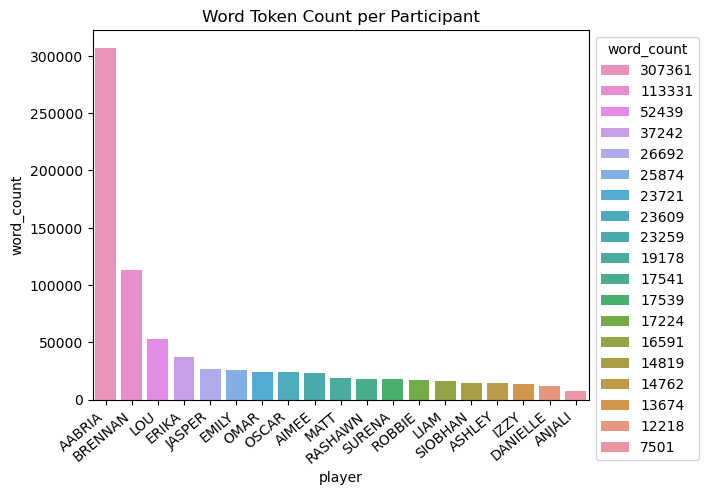

In [25]:
wtok = sns.barplot(countsdf, x="player", y="word_count", hue="word_count", dodge=False)
wtok.set_title("Word Token Count per Participant")
wtok.set_xticklabels(wtok.get_xticklabels(), rotation=40, ha="right")
sns.move_legend(wtok, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

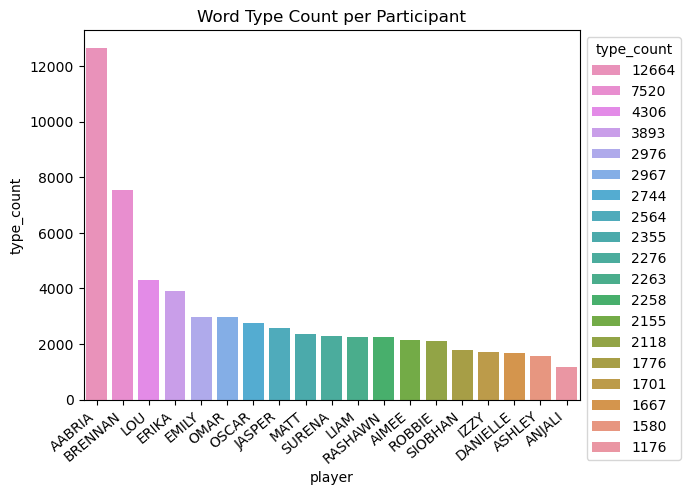

In [26]:
countsdf = countsdf.sort_values('type_count', ascending=False)

wcountplot = sns.barplot(countsdf, x="player", y="type_count", hue="type_count", dodge=False)
wcountplot.set_title("Word Type Count per Participant")
wcountplot.set_xticklabels(wcountplot.get_xticklabels(), rotation=40, ha="right")
sns.move_legend(wcountplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

In [27]:
cond_d20 = cond_d20.drop('nopunc', axis=1)

### Sentences and sentence length

In [28]:
sents = cond_d20.speech.map(nltk.sent_tokenize)

In [29]:
sentlength = sents.map(len)    #number of sentences spoken per line
cond_d20['sents_count'] = sentlength

In [30]:
cond_d20['sents_count'].describe()

count    63602.000000
mean         1.461149
std          1.275981
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         76.000000
Name: sents_count, dtype: float64

Wow, CR had a lenghty 27 sentence speech, what is possibly this long?!

In [31]:
cond_d20[cond_d20['sents_count']==76]

,key,player,speech,word_count,types,type_count,sents_count
28472,28473,AABRIA,"Damned by faint praise. Like, in comparison t...",603,"{curtsy, magical, such, often, telling, wow, o...",231,76


In [32]:
cond_d20.speech[28472]

" Damned by faint praise. Like, in comparison to any fey ever, how does a normal face do anything? And she walks over to you and looks at you and kind of takes you in, too, and gives a deep curtsy, well executed, well balanced, and you can see that her head is just sort of on a swivel as she looks around with wide eyes, just fully dazzled by everything she sees and everyone she meets.  It's a pleasure to meet you. Hi.  Hi, it's a pleasure to meet you as well. What was your name?  Wannessa.  Wannessa, that's right. So, Wannessa, how are you... How are you adjusting? Welcome.  Thank you. I'm good. Everything's just so grand. It really is breathtaking. You are lovely. Wow.  You are so weird.   And I like it—no, it's a compliment! I really enjoy it!  How am I weird? I don't—  Well, you have, like, these hands, but I feel like you should have more thumbs, because the thumb is the most useful finger on a hand, and you only have one, and you can't get more thumbs, you know?   Yeah, you're rig

### A closer look

I was fascinated by this and had to have a closer look at the original to verify this was all one speaker, and it is! The original transcript can be found [here](https://docs.google.com/document/d/e/2PACX-1vS6QswLcRjDTMSK57oj4o3WVKf6ykyoaNSqjBDuQgkPqJ_dkR0MB28U4NbUxFWE5g0oTJQJ7zAF-B44/pub), from Episode four. It's a back and forth between two NPCs (Non-Player Characters), both of course voices by the DM (since they are not player characters). Not one long speech by Aabria exactly.

In [33]:
avgsentlength = cond_d20.word_count/sentlength    #avg length of sentence per line or speech event
cond_d20['avg_sent_length']=avgsentlength
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].fillna(0)
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].map("{:.2f}".format)
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].map(float)
cond_d20.head()

,key,player,speech,word_count,types,type_count,sents_count,avg_sent_length
0,1,AABRIA,Let's start with Robbie.,5,"{'s, start, robbie, with, let}",5,1,5.0
1,2,ROBBIE,I'm so excited!,4,"{so, i, excited, 'm}",4,1,4.0
2,3,AABRIA,Yeah!,1,{yeah},1,1,1.0
3,4,ROBBIE,Whew!,1,{whew},1,1,1.0
4,5,AABRIA,Liam!,1,{liam},1,1,1.0


Another closer look...

In [34]:
cond_d20['avg_sent_length'].describe()

count    63602.000000
mean         7.262841
std          7.327353
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max        133.000000
Name: avg_sent_length, dtype: float64

In [35]:
cond_d20[cond_d20['avg_sent_length']==133]

,key,player,speech,word_count,types,type_count,sents_count,avg_sent_length
35882,35883,OMAR,"It can be really simple, where you just let w...",133,"{letting, different, kind, that, drops, beat, ...",77,1,133.0


In [36]:
cond_d20.speech[35882]

" It can be really simple, where you just let water drip down the glowworm trails, because glowworms have that little sticky lines of just, ba-ba-ba-ba, and that's how they trap flies and stuff in caves, and it's letting the water drop, but you kind of tap the worms so they have different lengths so the water drops at different heights to make different noises, but you can actually also guide different trails of water, similar to a synthesizer, but you just encourage more water down certain lines so that you have a pentatonic beat going here, and then you have sort of a melody going on with these other worms, and that's kind of just, I don't know, I guess it's a little thing that never came up."

Very similarly to the longest sentence in the Critical Role data, this is quite a run-on. Again, though, it seems like an accurate transcription of the speech itself. A focus on capturing the reality of what Omar was saying as he delivered a kind of rambling story about glowworms rather than grammaticality of written language.

In [37]:
sentcount = pd.DataFrame(cond_d20.groupby('player').sents_count.sum())
sentcount = sentcount.reset_index()
sentcount = sentcount.sort_values('sents_count', ascending=False)

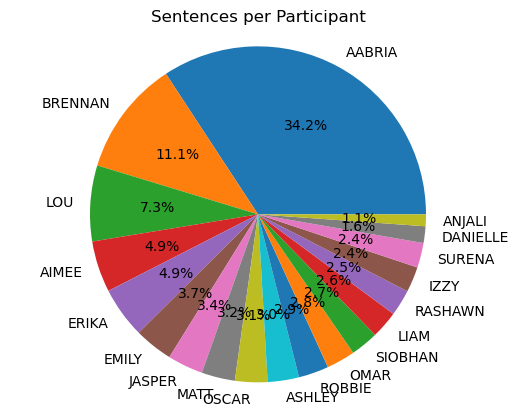

In [38]:
plt.pie(sentcount['sents_count'], labels=sentcount['player'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentences per Participant')
plt.show()

### Average sentence length per speaker

In [39]:
slen = pd.DataFrame(cond_d20.groupby('player').avg_sent_length.mean())
slen = slen.reset_index()
slen['avg_sent_length'] = slen['avg_sent_length'].map("{:.2f}".format)
slen['avg_sent_length'] = slen['avg_sent_length'].map(float)
slen = slen.sort_values('avg_sent_length', ascending=False)

In [40]:
#avgsents = slen[slen['avg_sent_length']>15]

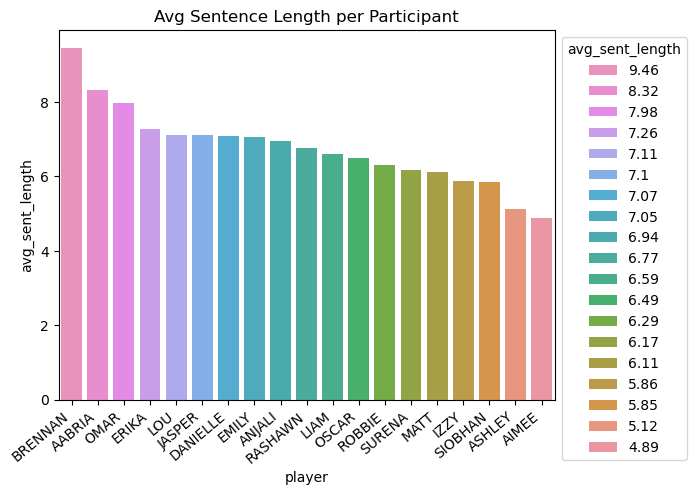

In [41]:
slenplot = sns.barplot(slen, x="player", y="avg_sent_length", hue="avg_sent_length", dodge=False)
slenplot.set_title("Avg Sentence Length per Participant")
slenplot.set_xticklabels(slenplot.get_xticklabels(), rotation=40, ha="right")
sns.move_legend(slenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

Since the "long sentences" measurement I did with the CR data was not very informative I decided to not replicated it with d20 data. 

## Initial Conlusions

My major takeaways from the data in Part 1 can be categorized the same as in my Critical Role analysis, with some difference in details:

1. DM leading<br>
The DM leads in almost all speech aspects, word token and type count, speech turns, and sentence count. The one exception to this is in average sentence length. In that category, she is beat out by the player Brennan by a full word longer on average. For some added context, Brennan is also a DM frequenctly on other seasons of Dimension 20 and may be prone to narrate a bit more at length than her.<br>
<br>
2. Player speech distribution<br>
The total player distribution appears unbalanced at first glance, but we need to keep in mind again that Brennan appears in 3 of the 4 seasons in question here and Erika and Lou both appear in 2 seasons. When averaged out to a per season count, those three players all drop to by just about the same percentage totals of all other players.<br>
Speech Turn %: Brennan 2.9%, Lou 3.4%, Erika 2.5%<br>
Word Count %: Brennan 4.8%, Lou 3.4%, Erika 2.4%<br>
Sentence Count %: Brennan 3.7%, Lou 3.7%, Erika 2.5%<br>
This leaves Brennan still in the lead for total word count, but Aimee in the lead for both Speech turn and sentence count. I know that this was Aimee's first time ever playing D&D, it may be the case here that she had more questions than some of the other players!

Similarly to the CR data as well, some of the players with the fewest speech turns had some of the longer (but not longest) sentences. Danielle, Anjali, and Rashawn all moved forward in the stats when it comes to average sentence length. 

## Dividing the Data

To take a look at the *dynamics* of a D&D table, I want to look at some of the metrics I've just built up when split by gender, and when split by role (DM or player). 

Where that puts this particular dataset is at a split of 8 women players, 8 men players, and 2 nonbinary players who both use she/they. And, of course, our DM. 

In [42]:
women_df = cond_d20[cond_d20['player'].isin(['ASHLEY', 'AIMEE', 'ANJALI', 'EMILY',  'RASHAWN', 'SIOBHAN', 'IZZY',  'DANIELLE'])]

In [43]:
men_df = cond_d20[cond_d20['player'].isin(['ROBBIE', 'LIAM', 'MATT', 'OMAR', 'LOU', 'OSCAR', 'BRENNAN', 'JASPER'])]

In [44]:
nb_df = cond_d20[cond_d20['player'].isin(['ERIKA', 'SURENA', ])]

In [45]:
aabria =  pd.DataFrame(cond_d20[cond_d20['player']=='AABRIA'])

## Re-measuring

Who is talking more between groups, who says more words, has longer sentences? 

I'm going to re-measure for total line counts, word counts, and average sentence lengths.

### Lines

In [46]:
#total number of lines/speech turns for all women
womenlcount = women_df[['speech']].copy()
womenlcount = womenlcount[womenlcount['speech'] != '']
womenlcount['val'] = 'women'
womenlcount = pd.DataFrame(womenlcount['speech'].groupby(womenlcount['val']).count())
womenlcount = womenlcount.reset_index()
womenlcount['speech']

0    16396
Name: speech, dtype: int64

In [47]:
#total number of lines/speech turns for men, not including the DM
menlcount = men_df[['speech']].copy()
menlcount = menlcount[menlcount['speech'] != '']
menlcount['val'] = 'men'
menlcount = pd.DataFrame(menlcount['speech'].groupby(menlcount['val']).count())
menlcount = menlcount.reset_index()
menlcount['speech']

0    22514
Name: speech, dtype: int64

In [48]:
nblcount = nb_df[['speech']].copy()
nblcount = nblcount[nblcount['speech'] != '']
nblcount['val'] = 'nonbinary'
nblcount = pd.DataFrame(nblcount['speech'].groupby(nblcount['val']).count())
nblcount = nblcount.reset_index()
nblcount['speech']

0    4464
Name: speech, dtype: int64

In [49]:
aablcount = aabria[['speech']].copy()
aablcount = aablcount[aablcount['speech'] != '']
aablcount['val'] = 'DM'
aablcount = pd.DataFrame(aablcount['speech'].groupby(aablcount['val']).count())
aablcount = aablcount.reset_index()
aablcount['speech']

0    19488
Name: speech, dtype: int64

In [50]:
mnw=[womenlcount, menlcount, nblcount]
dmnw = [womenlcount, menlcount, aablcount, nblcount]

mnwlines = pd.concat(mnw)
all_lines = pd.concat(dmnw)

Text(0.5, 1.0, 'Total Speech Turns by Gender (Including DM)')

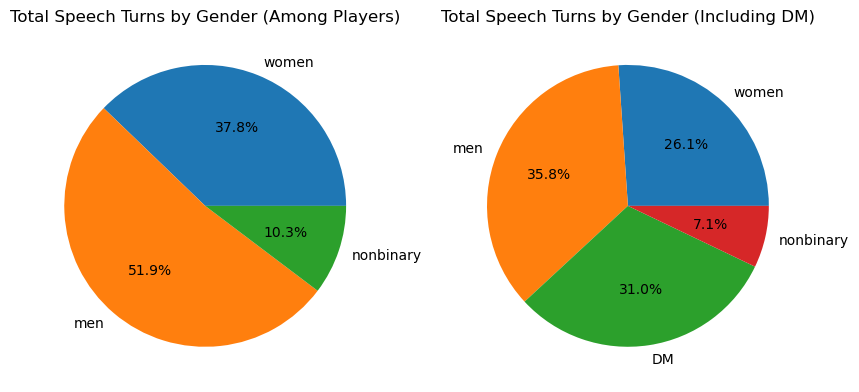

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwlines['val']
values = mnwlines['speech']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Speech Turns by Gender (Among Players)')


labels = all_lines['val']
values = all_lines['speech']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Speech Turns by Gender (Including DM)')

### Speech turn % of totals

- Women players (8 people) in 4 Dimension 20 campaigns contributed **26.1%** of all speech turns among players
- Men players (4 people) in 4 Dimension 20 campaigns contributed **35.8%** of all speech turns in total
- Nonbinary players (2 people) in 4 Dimension 20 campaigns contributed **7.1%** 
- Aabria, the DM, singularly contributed **31%** of all speech turns

Men are producing 9.7% more lines than women in total. <br>
Between only players, men are producing 14.1% more lines than women and only contribute little more than half of all player speech turns. There are a few details to consider again:<br>
- M and W groups are equally numbered (8 people)<br>
- 2 men (Lou and Brennan) are in more seasons, and contribute more speech turns than the women have the chance to

### Word Count

In [52]:
womwcount = women_df[['word_count']].copy()
womwcount['val']='women'
womwcount = pd.DataFrame(womwcount['word_count'].groupby(womwcount['val']).sum())
womwcount = womwcount.reset_index()
womwcount.word_count

0    129648
Name: word_count, dtype: int64

In [53]:
menwcount = men_df[['word_count']].copy()
menwcount['val']='men'
menwcount = pd.DataFrame(menwcount['word_count'].groupby(menwcount['val']).sum())
menwcount = menwcount.reset_index()
menwcount.word_count

0    292785
Name: word_count, dtype: int64

In [54]:
nbwcount = nb_df[['word_count']].copy()
nbwcount['val']='nonbinary'
nbwcount = pd.DataFrame(nbwcount['word_count'].groupby(nbwcount['val']).sum())
nbwcount = nbwcount.reset_index()
nbwcount.word_count

0    54781
Name: word_count, dtype: int64

In [55]:
dmwcount = aabria[['word_count']].copy()
dmwcount['val']='DM'
dmwcount = pd.DataFrame(dmwcount['word_count'].groupby(dmwcount['val']).sum())
dmwcount = dmwcount.reset_index()
dmwcount.word_count

0    307361
Name: word_count, dtype: int64

In [56]:
mnwc = [womwcount, menwcount, nbwcount]
dmnwc = [womwcount, menwcount, dmwcount, nbwcount]

mnwcount = pd.concat(mnwc)
dmnwcount = pd.concat(dmnwc)

Text(0.5, 1.0, 'Total Words by Gender (Including DM)')

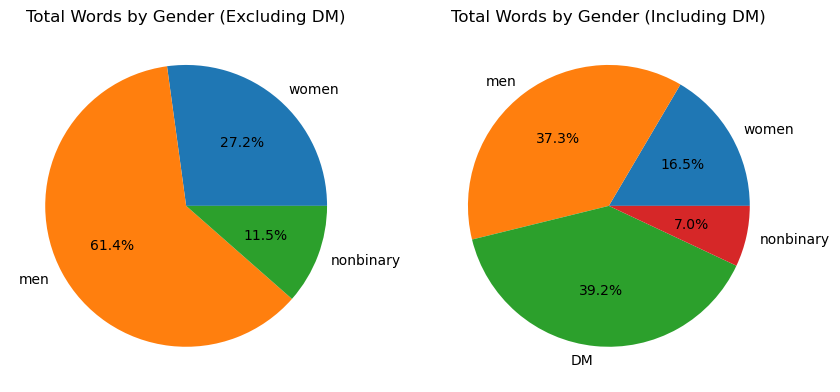

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwcount['val']
values = mnwcount['word_count']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Words by Gender (Excluding DM)')


labels = dmnwcount['val']
values = dmnwcount['word_count']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Words by Gender (Including DM)')

### Word % of totals

- Women players (8 people) in 4 Dimension 20 campaigns contributed **16.5%** of all spoken words 
- Men players (8 people) in 4 Dimension 20 campaigns contributed **37.3%** of all spoken words
- Nonbinary players (2 people) in 4 Dimension 20 campaigns contributed **7%**
- Matt, the DM, singularly contributed almost **39.2%** of all spoken words! So many words!

Men are producing 20.8% more words than women in total. <br>
Between only players, men are producing 34.2% more words than women and out nonbinary players share the smallest percentage at 11.5% among players.<br>

### Sentence Length

In [58]:
womscount = women_df[['avg_sent_length']].copy()
womscount['val']='women'
womscount = pd.DataFrame(womscount['avg_sent_length'].groupby(womscount['val']).mean())
womscount = womscount.reset_index()
womscount.avg_sent_length

0    5.895797
Name: avg_sent_length, dtype: float64

In [59]:
menscount = men_df[['avg_sent_length']].copy()
menscount['val']='men'
menscount = pd.DataFrame(menscount['avg_sent_length'].groupby(menscount['val']).mean())
menscount = menscount.reset_index()
menscount.avg_sent_length

0    7.415366
Name: avg_sent_length, dtype: float64

In [60]:
nbscount = nb_df[['avg_sent_length']].copy()
nbscount['val']='nonbinary'
nbscount = pd.DataFrame(nbscount['avg_sent_length'].groupby(nbscount['val']).mean())
nbscount = nbscount.reset_index()
nbscount.avg_sent_length

0    6.931799
Name: avg_sent_length, dtype: float64

In [61]:
aabscount = aabria[['avg_sent_length']].copy()
aabscount['val']='DM'
aabscount = pd.DataFrame(aabscount['avg_sent_length'].groupby(aabscount['val']).mean())
aabscount = aabscount.reset_index()
aabscount.avg_sent_length

0    8.319386
Name: avg_sent_length, dtype: float64

In [62]:
dmnws = [womscount, menscount, aabscount, nbscount]

dmnwslen = pd.concat(dmnws)

dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map("{:.2f}".format)
dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map(float)

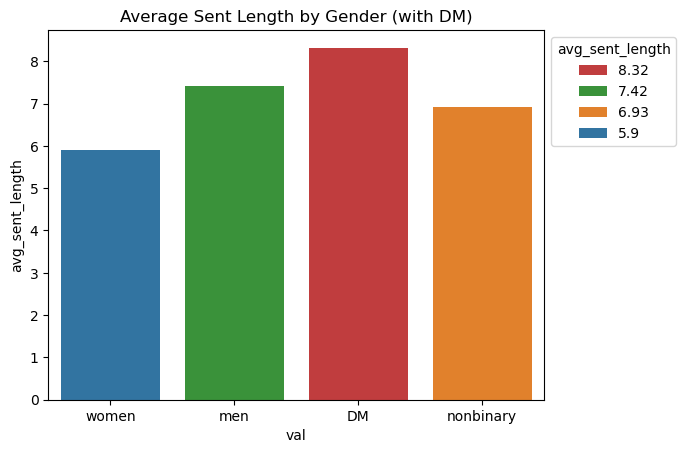

In [63]:
dmnwslenplot = sns.barplot(dmnwslen, x="val", y="avg_sent_length", hue="avg_sent_length", dodge=False)
dmnwslenplot.set_title("Average Sent Length by Gender (with DM)")
sns.move_legend(dmnwslenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

### Sentence length % of totals

- Women players (8 people) in 4 Dimension 20 campaigns have an average of 5.9 words per sentence
- Men players (8 people) in 4 Dimension 20 campaigns have an average of 7.42 words per sentence
- Nonbinary players (2 people) in 4 Dimension 20 campaigns have an average of 6.93 words per sentence
- Aabria, the DM, has an average of 8.32 words per sentence

As was the case with Critical Role, it's unsurprising the DM would have longer sentences on average compared to her players. However, she doesn't lead by very many words overall! 

Altogether, Dimension 20 sentences are quite long! Or at least are longer than the sentences by gender and role in Critical Role. I will address this too in in my final report where I compare the figures across notebooks.

## Grouped Conclusions

Aabria has a fairly healthy lead across measurements when divided by gender and role (player vs DM). Taking roughly a third of all speech turns across the table and nearly 40% of all spoken words. 

Between men, women, and nonbinary players, men take almost half of all speech turns, but produce 61% of all spoken words. When you consider the average sentence length table above, it adds up that while men are only speaking half of the time, they are cramming more words on average into those sentences when they *are* speaking. Women are speaking up often, but not saying quite so many words when they do. 

For nonbinary players, it's hard to really say conclusively if they are proportionally speaking across the data. Erika, as we saw in part 1 above, appears in more seasons than some of the other players and therefore contributes much more than the one-time players, so it's not so simple as looking at if they're contributing 1/4 as much as men or women (since there are 2 to the others' 8). However, for a group of only two players, they have a healthy representation on average.

Again, one dynamic to consider in regards to this data is that Aabria is the one full constant across the set. There is a *lot* of variety in player across some seasons of varying lengths, which makes identifying a "normal" much more unlikely. I believe that these graphs and figures would look a bit different if Aabria was DMing a regular group of players on a long term basis.

## Hedging

A "softening" of language associated with cautiousness, or being unsure of oneself. Think "evidence *seems* to suggest" or "it *might* be the case that". Hedging and gender has been a topic of study for [decades](https://www.scirp.org/journal/paperinformation?paperid=103664), but it's not a simple as saying women or men use more hedging language. They use different hedging language options depending on setting, formality, politeness expectations, and for different purposes. 

We're going to be looking at a list of single words, and three phrases using list comprehension and string counts.

In [64]:
hedge = ['maybe', 'might', 'perhaps', 'possibly', 'appears', 'seems', 'suggests', 'tends']  #hedging words

In [65]:
womlist = women_df['speech'].tolist()   #get the speech column from the women only df
womlist = [w.lower() if isinstance(w, str) else w for w in womlist]   #if it is a str, lowercase and return full text
womtoks = [nltk.word_tokenize(s) for s in womlist]   #tokenize
womtoks = list(itertools.chain(*womtoks))  #flatten list of lists into one list

In [66]:
womhedg = [w for w in womtoks if w in hedge]  #return list of words in women_df speech that appear in hedging list
len(womhedg)   #get total count

356

In [67]:
print(women_df['speech'].str.count(r'I guess').sum())   #get count for each hedging phrase
print(women_df['speech'].str.count(r'I think').sum())
print(women_df['speech'].str.count(r'[C|c]ould be').sum())

93
418
32


In [68]:
(899/129648)*1000  #total hedging counts for women / total words for women

6.934160187584845

In [69]:
menlist = men_df['speech'].tolist()
menlist = [w.lower() if isinstance(w, str) else w for w in menlist]
mentoks = [nltk.word_tokenize(s) for s in menlist]
mentoks = list(itertools.chain(*mentoks))

In [70]:
menhedg = [w for w in mentoks if w in hedge]
len(menhedg)

627

In [71]:
print(men_df['speech'].str.count(r'I guess').sum())
print(men_df['speech'].str.count(r'I think').sum())
print(men_df['speech'].str.count(r'[C|c]ould be').sum())

99
1063
41


In [72]:
(1830/292785)*1000  #total hedging words for men / total words for men

6.25032020082996

In [73]:
nblist = nb_df['speech'].tolist()
nblist = [w.lower() if isinstance(w, str) else w for w in nblist]
nbtoks = [nltk.word_tokenize(s) for s in nblist]
nbtoks = list(itertools.chain(*nbtoks))

In [74]:
nbhedg = [w for w in nbtoks if w in hedge]
len(nbhedg)

150

In [75]:
print(nb_df['speech'].str.count(r'I guess').sum())
print(nb_df['speech'].str.count(r'I think').sum())
print(nb_df['speech'].str.count(r'[C|c]ould be').sum())

27
122
10


In [76]:
(309/54781)*1000  #total hedging words for nb players / total words for nb players

5.640641828371151

In [77]:
aablist = aabria['speech'].tolist()
aablist = [w.lower() if isinstance(w, str) else w for w in aablist]
aabtoks = [nltk.word_tokenize(s) for s in aablist]
aabtoks = list(itertools.chain(*aabtoks))

In [78]:
aabhedg = [w for w in aabtoks if w in hedge]
len(aabhedg)

273

In [79]:
print(aabria['speech'].str.count(r'I guess').sum())
print(aabria['speech'].str.count(r'I think').sum())
print(aabria['speech'].str.count(r'[C|c]ould be').sum())

38
371
40


In [80]:
(722/307361)*1000  #total hedging words for Aabria / total words for Aabria

2.3490293173174215

### Hedging Conclusions

Women have 899 instances of hedging phrases<br>
Men have 1930 instances<br>
Nonbinary players have 309 instances<br>
The DM, Aabria, has 722 instances

### Hedging Frequency

I'm be using normalized frequency to determine a frequency per thousand words for a reasonable measurement of how often jargon is appearing per group. Information about calculating this can be found [here](https://www.english-linguistics.uni-mainz.de/corpus-linguistics/american-and-british-english-corpora/more-information-about-coca-and-coha/)

With the raw count of hedging words & phrases as high as it is, I chose to calculate per 1 thousand words.<br>
For every thousand words spoken per group:<br>
**6.93** words spoken by women, <br>
**6.25** words spoken by men,<br>
**5.64** words spoken by nonbinary players, and<br>
**2.34** words spoken by the DM are among the scanned for hedging words and phrases.

Similarly to the CR hedging values, the players are not all *that* different between player groups per thousand spoken words. Once again, the DM has the lowest amount of hedging, however when you consider that she is one person while the other groups comprise of 8 people (men and women) and 2 people (nb players), 2.34 words per every thousand words is still quite high!

## Jargon

Dungeons & Dragons has a pretty unique vocabulary that can be tricky to learn and understand for new players and can be relatively unclear in meaning to those unfamiliar with the game. 

See the process I used to make a list of D&D jargon in my notebook [here](https://github.com/Data-Science-for-Linguists-2025/Critical-Role-Analysis/blob/main/notebooks/DND_Jargon.ipynb). Extracting words from the Player's Handbook that could not be dound in the Norvig Google unigram frequency list. It's not a complete collection of words I would consider "jargon-y" to the game, but it's a pretty good starting point.

In [81]:
jargon = pd.read_pickle('../pickle_jar/jargonlist.pkl') #jargon list as created in PHB_Jargon notebook
jargon[453:458]

['undercommon', 'rerolls', 'abbathor', 'tharizdun', 'caltrops']

In [82]:
womjarg = [w for w in womtoks if w in jargon]  #using the same method as hedging, list comprehend for jargon examples
len(womjarg)

20

In [83]:
(20/129648)*1000000

154.26385289398988

In [84]:
menjarg = [w for w in mentoks if w in jargon]
len(menjarg)

62

In [85]:
(62/292785)*1000000

211.7594822139112

In [86]:
nbjarg = [w for w in nbtoks if w in jargon]
len(nbjarg)

4

In [87]:
(4/54781)*1000000

73.01801719574306

In [88]:
aabjarg = [w for w in aabtoks if w in jargon]
len(aabjarg)

62

In [89]:
(62/307361)*1000000

201.71719899401683

### Jargon Frequency Results

Although the count of total words per group in this dataset are in the 100,000 to 300,000 range, I am still calculating the frequency of jargon per million spoken words so that our measurements can be comparable to the Critical Role jargon frequency in an understandable way.

What this means is that for every million words spoken by the members of the group in question:<br>
**154.26** words spoken by the women players,<br>
**211.75** words spoken by men players,<br> 
**73.01** words spoken by nb players, and<br>
**201.71** words spoken by the DM will be from this jargon list.<br>
<br>
<br>
Which words from the list of D&D jargon are being used? 

In [90]:
from wordcloud import WordCloud

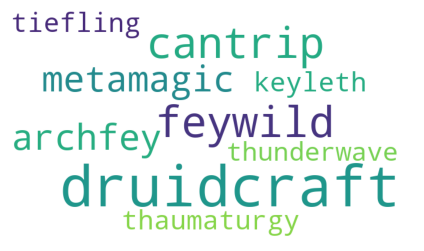

In [91]:
unique_string=(" ").join(womjarg)
wordcloud = WordCloud(background_color='white', width = 700, height = 400).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

### Women

Above is the women's wordcloud for jargon in their D20 seasons. I will approach the drop in jargon presence in my conclusions below.

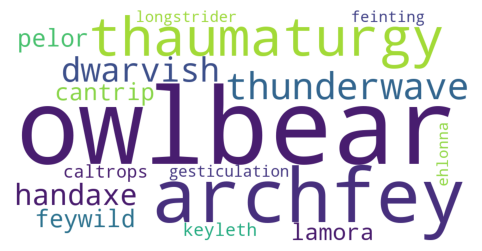

In [92]:
unique_string=(" ").join(menjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Men

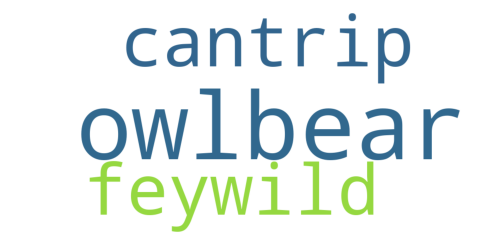

In [93]:
unique_string=(" ").join(nbjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Nonbinary

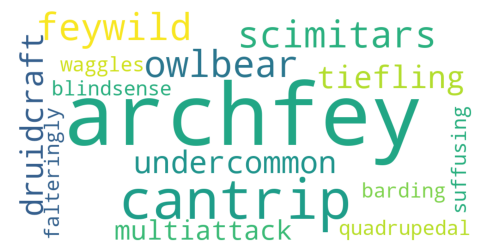

In [94]:
unique_string=(" ").join(aabjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### DM

## Jargon Conclusions

These word clouds are pretty sparse! Unlike in the Critical Role speech data, it's difficult to discern what *kind* of characters are being played by word cloud alone. There are spells and creatures, but not so much that I can pinpoint who was playing magic users or fighting types. Even the DM cloud is filled with relatively normal English words that just didn't happen to appear in the Google unigram data, like *falteringly*, *waggles*, and *quadrupedal*. 

I have a theory for why this is that I will adress in my final analysis write up.

## Readability Metric

### Flesch–Kincaid readability test

Reminder that the calculation for the readability score is calculated as:<br>
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e>

and the grade level calculation is:
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/8e68f5fc959d052d1123b85758065afecc4150c3>

Full details about the test can also be found in my notebook [here](https://github.com/Data-Science-for-Linguists-2025/Critical-Role-Analysis/blob/main/notebooks/DND_Jargon.ipynb), but as a basic recap:
According to the test's creator, number of appearances of multisyllabic words is a generally reliable indicator of how difficult a document is to read. My intention of using it here is as an analog for how "approachable" this kind of D&D language can be to people.

In [95]:
from nltk.tokenize import SyllableTokenizer
import warnings
warnings.filterwarnings('ignore')

In [96]:
SSP = SyllableTokenizer()

### Women

In [97]:
wnopunc = [w for w in womtoks if w not in punctuations]  #removing punctuation for syl tokenizer
wsyls = [SSP.tokenize(w) for w in wnopunc] #syl tokenize for each tokenized word
wsylcount = [len(w) for w in wsyls]   #count syllable per word in full list
sum(wsylcount)  #total count all syllables for women

176356

In [98]:
#readability calculation for women speech

206.853-(1.015*(129648/20495))-(84.6*(176356/129648))

85.3536208434905

In [99]:
#grade score for women speech 

(0.39*(129648/20495))+(11.8*(176356/129648))-15.59

2.928235936337707

### Men

In [100]:
mnopunc = [w for w in mentoks if w not in punctuations]  
msyls = [SSP.tokenize(w) for w in mnopunc] 
msylcount = [len(w) for w in msyls]   
sum(msylcount) 

409031

In [101]:
#readability calculation for men speech

206.853-(1.015*(292785/33844))-(84.6*(409031/292785))

79.88302625599124

In [102]:
#grade score for men speech 

(0.39*(292785/33844))+(11.8*(409031/292785))-15.59

4.268913740582349

### Nonbinary

In [103]:
nbnopunc = [w for w in nbtoks if w not in punctuations]  
nbsyls = [SSP.tokenize(w) for w in nbnopunc] 
nbsylcount = [len(w) for w in nbsyls]   
sum(nbsylcount) 

76858

In [104]:
#readability calculation for nb speech

206.853-(1.015*(54781/6781))-(84.6*(76858/54781))

79.95902210116529

In [105]:
#grade score for men speech 

(0.39*(54781/6781))+(11.8*(76858/54781))-15.59

4.1161101292925295

### DM

In [106]:
dmnopunc = [w for w in aabtoks if w not in punctuations]  
dmsyls = [SSP.tokenize(w) for w in dmnopunc] 
dmsylcount = [len(w) for w in dmsyls]   
sum(dmsylcount) 

444592

In [107]:
#readability calculation for DM speech

206.853-(1.015*(307361/31812))-(84.6*(444592/307361))

74.67394398265746

In [108]:
#grade score for DM speech 

(0.39*(307361/31812))+(11.8*(444592/307361))-15.59

5.246581461327498

## Readability Conclusions

At [this](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests) listing, there is a "reading ease" table that assigns grade levels to the reading score as calculated, which are generally different than the grade level calculation result. I tend to consider both overall when considering a score, to best get a feel for an accurate measurement. (As accurate as we can hope to be, in this case).

In this instance, the results were:
Women: 85
Men: 79
Nonbinary: 80
DM: 75

For the score conversion from the table linked above, this puts the speech data from Dimension 20 in a 6th/7th grade difficulty bracket. However, the grade calculation gives a result of around 3rd to 5th grade. 

As I said, this is a test not intended for spoken data, which I expect would have a much higher appearance of single-syllable words (pronouns, function words, etc) when compared to written language. This would surely affect the scores quite a lot. I take these scores cautiously, even more than I did with the Player's Handbook score I calculated, but it is still interesting to consider. For instance, the fact that the DM has a lower (ie more difficult) readability score than the players indicates, to me, that he is generally using some of the more technical and jargon-y D&D language than they are.

## Readability Redux

Remeasuring readability with the secondary method used [here](https://github.com/Data-Science-for-Linguists-2025/Critical-Role-Analysis/blob/main/notebooks/ReadabilityRedux.ipynb)

In [109]:
import phonemizer
from phonemizer.backend.espeak.wrapper import EspeakWrapper

# Must point to eSpeak NG's library dll
EspeakWrapper.set_library(r'C:\Program Files\eSpeak NG\libespeak-ng.dll')

from phonemizer.backend import EspeakBackend
from phonemizer.punctuation import Punctuation

In [110]:
vowels = ['ᵻ', 'ɪ', 'e', 'ɛ', 'æ', 'ʌ', 'ə', 'u', 'ʊ', 'ɔ', 'ɑ', 'i', 'ɐ', 'ɚ', 'ɜ', 'a', 'o']

In [111]:
backend = EspeakBackend('en-us')

### Women

In [112]:
womphon = backend.phonemize(wnopunc)

In [113]:
womphon = [(re.sub(r'(.*)eɪ(.*)', r'\1e\2', w)) for w in womphon]
womphon = [(re.sub(r'(.*)oʊ(.*)', r'\1o\2', w)) for w in womphon]
womphon = [(re.sub(r'(.*)aɪ(.*)', r'\1a\2', w)) for w in womphon]
womphon = [(re.sub(r'(.*)aʊ(.*)', r'\1a\2', w)) for w in womphon]
womphon = [(re.sub(r'(.*)ɔɪ(.*)', r'\1ɔ\2', w)) for w in womphon]

In [114]:
womvowels = [[c for c in w if c in vowels] for w in womphon]

In [115]:
womvcount = [len(w) for w in womvowels]

In [116]:
sum(womvcount)

160165

In [117]:
206.853-(1.015*(129648/20495))-(84.6*(160165/129648))

95.9188328020244

In [118]:
(0.39*(129648/20495))+(11.8*(160165/129648))-15.59

1.4546011714358187

### Men

In [119]:
menphon = backend.phonemize(mnopunc)

In [120]:
menphon = [(re.sub(r'(.*)eɪ(.*)', r'\1e\2', w)) for w in menphon]
menphon = [(re.sub(r'(.*)oʊ(.*)', r'\1o\2', w)) for w in menphon]
menphon = [(re.sub(r'(.*)aɪ(.*)', r'\1a\2', w)) for w in menphon]
menphon = [(re.sub(r'(.*)aʊ(.*)', r'\1a\2', w)) for w in menphon]
menphon = [(re.sub(r'(.*)ɔɪ(.*)', r'\1ɔ\2', w)) for w in menphon]

In [121]:
menvowels = [[c for c in w if c in vowels] for w in menphon]

In [122]:
menvcount = [len(w) for w in menvowels]

In [123]:
sum(menvcount)

370807

In [124]:
206.853-(1.015*(292785/33844))-(84.6*(370807/292785))

90.92782158362071

In [125]:
(0.39*(292785/33844))+(11.8*(370807/292785))-15.59

2.7283867327096765

### Nonbinary

In [126]:
nbphon = backend.phonemize(nbnopunc)

In [127]:
nbphon = [(re.sub(r'(.*)eɪ(.*)', r'\1e\2', w)) for w in nbphon]
nbphon = [(re.sub(r'(.*)oʊ(.*)', r'\1o\2', w)) for w in nbphon]
nbphon = [(re.sub(r'(.*)aɪ(.*)', r'\1a\2', w)) for w in nbphon]
nbphon = [(re.sub(r'(.*)aʊ(.*)', r'\1a\2', w)) for w in nbphon]
nbphon = [(re.sub(r'(.*)ɔɪ(.*)', r'\1ɔ\2', w)) for w in nbphon]

In [128]:
nbvowels = [[c for c in w if c in vowels] for w in nbphon]

In [129]:
nbvcount = [len(w) for w in nbvowels]

In [130]:
sum(nbvcount)

68996

In [131]:
206.853-(1.015*(54781/6781))-(84.6*(68996/54781))

92.10055292389579

In [132]:
(0.39*(54781/6781))+(11.8*(68996/54781))-15.59

2.42261055827338

### DM

In [133]:
dmphon = backend.phonemize(dmnopunc)

In [134]:
dmphon = [(re.sub(r'(.*)eɪ(.*)', r'\1e\2', w)) for w in dmphon]
dmphon = [(re.sub(r'(.*)oʊ(.*)', r'\1o\2', w)) for w in dmphon]
dmphon = [(re.sub(r'(.*)aɪ(.*)', r'\1a\2', w)) for w in dmphon]
dmphon = [(re.sub(r'(.*)aʊ(.*)', r'\1a\2', w)) for w in dmphon]
dmphon = [(re.sub(r'(.*)ɔɪ(.*)', r'\1ɔ\2', w)) for w in dmphon]

In [135]:
dmvowels = [[c for c in w if c in vowels] for w in dmphon]

In [136]:
dmvcount = [len(w) for w in dmvowels]

In [137]:
sum(dmvcount)

392000

In [138]:
206.853-(1.015*(307361/31812))-(84.6*(392000/307361))

89.14970115419192

In [139]:
(0.39*(307361/31812))+(11.8*(392000/307361))-15.59

3.2275042199078

## New Results

In this instance, with the new phonemizer to syllable splitting method, the results were: Women: 96 Men: 91 Nonbinary: 92 DM: 89

Similar as we saw with the Critical Role data, everyone increased in "readability" (or easiness) by at least 10 points. And, just like the CR data, they players are all in the easiest ranking (easily understood by an 11 year old) and the DM remains the most complex at the table, but is still described in her ranking as "conversational".

## Interruptions

Studying interruptions in the D20 data has its own hurdles compared to the Critical Role dataset. There is no timestamp information encoded, which is a loss, but as we saw with the CR data, the timestamps weren't the most helpful at identifying interruptions anyway. 

Unlike in the CR data, though, interruptions are represented orthographically with a double hyphen at the end of the cut off statement. There's an example below of what this looks like. This may make it more simple to analyze interruption in this data, but without listening to the data along with it verification would be difficult. 

Finally, since studying interruption was not really possible with the Critical Role data and there wouldbe nothing to compare with, I did not elect to study it in depth here either.

In [140]:
cond_d20[cond_d20['speech'].str.contains(r'--$')]

,key,player,speech,word_count,types,type_count,sents_count,avg_sent_length
36558,36559,BRENNAN,I haven't spent that much time on this side o...,54,"{much, n't, table, time, like, seat, structure...",40,3,18.00
36718,36719,OSCAR,"Yeah, well you came out the gate swinging wit...",12,"{gate, --, out, that, monologue, swinging, the...",12,1,12.00
36722,36723,LOU,I'm similar to Emily in that I was nervous ab...,26,"{about, time, like, ahead, to, i, similar, ner...",20,1,26.00
36737,36738,AABRIA,"Oh man, I never know what questions to ask he...",12,"{know, questions, i, oh, man, --, what, never,...",12,1,12.00
36789,36790,OSCAR,"Oh. Oh, you're trying to--",7,"{oh, --, trying, to, 're, you}",6,2,3.50
...,...,...,...,...,...,...,...,...
64275,64276,AABRIA,"Mice and Murder was the last one before it, r...",275,"{in-person, real, protocols, an, needs, cool, ...",133,13,21.15
64277,64278,AABRIA,"We had delays, 'cause we had all the crew, al...",277,"{test, an, inside, cool, that, ``, breaking, t...",147,10,27.70
64279,64280,AABRIA,I think it was--,5,"{i, --, was, it, think}",5,1,5.00
64281,64282,AABRIA,"Those are the one, and just a little, teeny w...",104,"{once, work, people, up, and, window, shot, pr...",67,5,20.80


In [141]:
cond_d20.speech[36558]

" I haven't spent that much time on this side of the table. The table is structured for the person in that seat when they command that power to get really scary.  It's like Aabria, you're like, as that grandfather, I was like as as the grandfather and also as advisor--"

In [142]:
cond_d20.speech[36559]

' Oh, advisor!'

In [143]:
cond_d20.speech[36560]

" It's so, just it's there's just so much status. It's like..."